In [1]:
# import packages
import numpy as np, pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
# read data
brancher = pd.read_csv("data/arbejdsmarkedsanalyse_brancher.csv", sep = ";",decimal=",",  encoding="latin-1")
koenAlder = pd.read_csv("data/arbejdsmarkedsanalyse_koen_alder.csv", sep = ";",decimal=",",  encoding="latin-1")

pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', None)

# Køn og Alder

In [8]:
koenAlder.head()

,Group,Question Label,Topic Label,Year,Akse,Ordforklaring,Antpers,Farveskala,Gennemsnit,Score (Indekseret score) (gennemsnit) (label),Score (Indekseret score) (gennemsnit),Score (Indekseret score),Score
0,"Mænd, 55 - 64 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5080,38.852616,NaN,NaN,NaN,18.223967,0.911198
1,"Mænd, 45 - 54 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5367,29.425529,NaN,NaN,NaN,19.637802,0.981890
2,"Mænd, 35 - 44 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",3496,18.435371,NaN,NaN,NaN,21.286060,1.064303
3,"Mænd, 25 - 34 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",1876,2.222449,NaN,NaN,NaN,23.717605,1.185880
4,"Mænd, 18 - 24 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",591,9.439167,NaN,NaN,NaN,22.635273,1.131764


In [15]:
ka_timer = koenAlder[koenAlder['Akse'] == 'Timer']
ka_score = koenAlder[koenAlder['Akse'] == 'Score']
ka_andel = koenAlder[koenAlder['Akse'] == 'Andel (%)']


In [16]:
ka_timer.describe()

,Year,Antpers,Farveskala,Gennemsnit,Score (Indekseret score) (gennemsnit) (label),Score (Indekseret score) (gennemsnit),Score (Indekseret score),Score
count,12.0,12.000000,12.000000,0.0,0.0,0.0,12.000000,12.000000
mean,2018.0,6257.833333,5.126559,NaN,NaN,NaN,36.737113,36.737113
std,0.0,6185.572110,28.327155,NaN,NaN,NaN,3.585739,3.585739
min,2018.0,703.000000,-29.283903,NaN,NaN,NaN,28.434586,28.434586
25%,2018.0,2408.000000,-15.144933,NaN,NaN,NaN,35.189981,35.189981
50%,2018.0,4864.500000,8.662648,NaN,NaN,NaN,36.289504,36.289504
75%,2018.0,5988.500000,17.348826,NaN,NaN,NaN,39.303142,39.303142
max,2018.0,20170.000000,70.716097,NaN,NaN,NaN,41.092896,41.092896


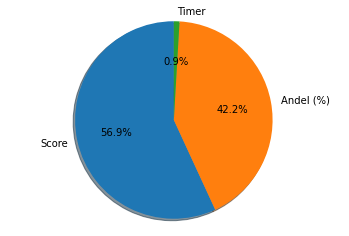

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =  ['Score', 'Andel (%)', 'Timer']
sizes = [len(ka_score), len(ka_andel), len(ka_timer)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:


print("Unikke emner: " + str(len(koenAlder["Topic Label"].unique())))

print("Unikke spørgsmål: " + str(len(koenAlder["Question Label"].unique())))
print("Unikke brancher: " + str(len(koenAlder["Group"].unique())))
print("Unikke brancher: " + str(len(koenAlder["Group"].unique())))
print("Unikke brancher: " + str(koenAlder["Akse"].unique()))

print("Unikke emner: " + str(koenAlder["Topic Label"].unique()))



Unikke emner: 37
Unikke spørgsmål: 109
Unikke brancher: 12
Unikke brancher: 12
Unikke brancher: ['Score' 'Andel (%)' 'Timer']
Unikke emner: ['Angstsymptomer' 'Arbejdsevne'
 'Arbejdspladsens prioritering af arbejdsmiljø' 'Arbejdsrelateret sygdom'
 'Arbejdstid' 'Belastende arbejdsstillinger' 'Depressive symptomer'
 'Egen indsats for arbejdsmiljø' 'Engagement og mening i arbejdet'
 'Fysisk hårdt arbejde' 'Følelsesmæssige krav'
 'Gående, stående og siddende arbejde' 'Helbred'
 'Hudpåvirkning og hudproblemer' 'Indflydelse' 'Jobusikkerhed'
 'Kollegial anerkendelse' 'Kollegial støtte og samarbejde'
 'Konflikter mellem arbejde og privatliv'
 'Kvantitative krav og grænseløshed' 'Ledelseskvalitet'
 'Løft, skub eller træk af byrder' 'Mentalt helbred' 'Negative oplevelser'
 'Nyansatte' 'Retfærdighed' 'Rolleklarhed' 'Rummelighed'
 'Sikkerhed på arbejdspladsen' 'Smerter' 'Støj og vibrationer'
 'Støv, dampe og gasser' 'Sundhedsfremmetilbud' 'Træthed og søvnproblemer'
 'Ulykker' 'Uoverskuelighed og st

# Brancher
Nedenfor ses et udsnit af datasættet indeholdende brancher. Observationer omkring variable:
- Topic label viser overordnet spørgsmålstype
- Question label viser spørgsmålstypen
- akse viser hvilken type score der er tale om
- score viser den absolutte middelscore i gruppen (samme som mean?)
- Score (Indekseret score) viser Score indekseret mellem 0 og 100
- Score (Indekseret score) (gennemsnit) (label) viser en form for justeret gennemsnit af Score/Mean
- Score (Indekseret score) (gennemsnit) viser Score (Indekseret score) (gennemsnit) (label) indekseret mellem 0 og 100
- Høj score godt: 1 = ja 0 = nej
- Rækker med Group='Total' viser den totale score pr. spørgsmål


In [4]:
print("Unikke emner: " + str(len(brancher["Topic Label"].unique())))

print("Unikke spørgsmål: " + str(len(brancher["Question Label"].unique())))
print("Unikke brancher: " + str(len(brancher["Group"].unique())))
print("Unikke brancher: " + str(len(brancher["Group"].unique())))
print("Unikke brancher: " + str(brancher["Akse"].unique()))

print("Unikke emner: " + str(brancher["Topic Label"].unique()))



Unikke emner: 37
Unikke spørgsmål: 109
Unikke brancher: 76
Unikke brancher: 76
Unikke brancher: ['Score' nan 'Andel (%)' 'Timer']
Unikke emner: ['Kvantitative krav og grænseløshed' 'Følelsesmæssige krav'
 'Konflikter mellem arbejde og privatliv' 'Træthed og søvnproblemer'
 'Jobusikkerhed' 'Ledelseskvalitet' 'Rolleklarhed' 'Retfærdighed'
 'Rummelighed' 'Indflydelse' 'Kollegial støtte og samarbejde'
 'Kollegial anerkendelse' 'Egen indsats for arbejdsmiljø' 'Arbejdsevne'
 'Helbred' 'Engagement og mening i arbejdet' 'Sikkerhed på arbejdspladsen'
 'Arbejdspladsens prioritering af arbejdsmiljø' 'Arbejdsrelateret sygdom'
 'Smerter' 'Arbejdstid' 'Negative oplevelser' 'Vold og trusler'
 'Støj og vibrationer' 'Støv, dampe og gasser'
 'Belastende arbejdsstillinger' 'Hudpåvirkning og hudproblemer'
 'Løft, skub eller træk af byrder' 'Uoverskuelighed og stress' 'Ulykker'
 'Gående, stående og siddende arbejde' 'Nyansatte' 'Depressive symptomer'
 'Angstsymptomer' 'Sundhedsfremmetilbud' 'Mentalt helbre

In [229]:
brancher[brancher['']]

In [225]:
brancher.head()

,Field Values Index,Ordforklaring,Akse,Farveskala,Field Values Index (Fixed),Navigation - Arbejdsmiljøprofiler,Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Antpct,Antpers,Group,Hoej Score Godt,Kategori10,Kategori11,Kategori12,Kategori13,Kategori14,Kategori15,Kategori1,Kategori2,Kategori3,Kategori4,Kategori5,Kategori6,Kategori7,Kategori8,Kategori9,Main Group,Score,Field Values,Mean,Question Label,Sluttekst,Spm Formulering,Topic Label,Type,Year
0,49.824544,"Spørgsmål: Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?\n\n- 1. Altid\n- 2. ...",Score,-5.059771,54.884315,Arbejdsmiljøprofiler,52.180881,2.609044,-2.609044,NaN,53.173963,NaN,NaN,224,Bibliotekarer og beskæftigede med kultur,0,NaN,NaN,NaN,NaN,NaN,NaN,1. Altid,2. Ofte,3. Sommetider,4. Sjældent,5. Aldrig,NaN,NaN,NaN,NaN,Job,2.658698,-2.658698,2.658698,Ikke nok tid til arbejdsopgaver,I resultaterne præsenteres den gennemsnitlige score (1-5).,"Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?",Kvantitative krav og grænseløshed,kont,2018
1,59.245851,"Spørgsmål: Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?\n\n- 1. Altid\n- 2. ...",Score,4.361536,54.884315,Arbejdsmiljøprofiler,52.180881,2.609044,-2.609044,NaN,51.324841,NaN,NaN,388,Bogholdere,0,NaN,NaN,NaN,NaN,NaN,NaN,1. Altid,2. Ofte,3. Sommetider,4. Sjældent,5. Aldrig,NaN,NaN,NaN,NaN,Job,2.566242,-2.566242,2.566242,Ikke nok tid til arbejdsopgaver,I resultaterne præsenteres den gennemsnitlige score (1-5).,"Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?",Kvantitative krav og grænseløshed,kont,2018
2,89.954233,"Spørgsmål: Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?\n\n- 1. Altid\n- 2. ...",Score,35.069918,54.884315,Arbejdsmiljøprofiler,52.180881,2.609044,-2.609044,NaN,45.297700,NaN,NaN,189,"Brandmænd, reddere og sikkerhedsvagter",0,NaN,NaN,NaN,NaN,NaN,NaN,1. Altid,2. Ofte,3. Sommetider,4. Sjældent,5. Aldrig,NaN,NaN,NaN,NaN,Job,2.264885,-2.264885,2.264885,Ikke nok tid til arbejdsopgaver,I resultaterne præsenteres den gennemsnitlige score (1-5).,"Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?",Kvantitative krav og grænseløshed,kont,2018
3,44.365260,"Spørgsmål: Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?\n\n- 1. Altid\n- 2. ...",Score,-10.519056,54.884315,Arbejdsmiljøprofiler,52.180881,2.609044,-2.609044,NaN,54.245458,NaN,NaN,182,Bude og kurerer,0,NaN,NaN,NaN,NaN,NaN,NaN,1. Altid,2. Ofte,3. Sommetider,4. Sjældent,5. Aldrig,NaN,NaN,NaN,NaN,Job,2.712273,-2.712273,2.712273,Ikke nok tid til arbejdsopgaver,I resultaterne præsenteres den gennemsnitlige score (1-5).,"Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?",Kvantitative krav og grænseløshed,kont,2018
4,85.447709,"Spørgsmål: Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?\n\n- 1. Altid\n- 2. ...",Score,30.563394,54.884315,Arbejdsmiljøprofiler,52.180881,2.609044,-2.609044,NaN,46.182196,NaN,NaN,280,"Bus- og taxachauffører, lokoførere m.fl.",0,NaN,NaN,NaN,NaN,NaN,NaN,1. Altid,2. Ofte,3. Sommetider,4. Sjældent,5. Aldrig,NaN,NaN,NaN,NaN,Job,2.309110,-2.309110,2.309110,Ikke nok tid til arbejdsopgaver,I resultaterne præsenteres den gennemsnitlige score (1-5).,"Hvor ofte oplever du, at du har nok tid til dine arbejdsopgaver?",Kvantitative krav og grænseløshed,kont,2018


In [231]:
print("Unikke emner: " + str(len(brancher["Question Label"].unique())))

print("Unikke spørgsmål: " + str(len(brancher["Question Label"].unique())))
print("Unikke brancher: " + str(len(brancher["Group"].unique())))
print("Unikke brancher: " + str(len(brancher["Group"].unique())))
print("Unikke brancher: " + str(brancher["Akse"].unique()))


Unikke emner: 109
Unikke spørgsmål: 109
Unikke brancher: 76
Unikke brancher: 76
Unikke brancher: ['Score' nan 'Andel (%)' 'Timer']


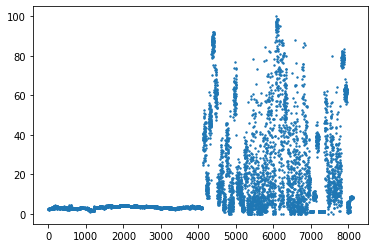

In [78]:
plt.figure()
plt.scatter(brancher.index, brancher.Score, s = 2)
plt.show()


In [260]:
brancher_filter = brancher.filter(items=['Group',
                                         'Akse',
                             'Topic Label',                                          
                             'Question Label', 
                             'Antpct', 
                             'Antpers',
                             'Hoej Score Godt',
                             'Field Values Index', 
                             'Field Values Index (Fixed)', 
                             'Score (Indekseret score) (gennemsnit)',
                             'Score (Indekseret score) (gennemsnit) (label)', 
                             'Score (Total) (Fixed)', 
                             'Gennemsnit', 
                             'Score (Indekseret score)',
                             'Score (Total)', 
                             'Score',
                             'Field Values',
                             'Mean'])

total=brancher_filter[brancher_filter.Group=='Total']
brancher_ex_total = brancher_filter[brancher_filter.Group!='Total']

brancher_score = brancher_ex_total[brancher_ex_total.Akse=='Score']
brancher_score = brancher_score[brancher_score.Score.notna()]
brancher_andel = brancher_ex_total[brancher_ex_total.Akse=='Andel (%)']
brancher_timer = brancher_ex_total[brancher_ex_total.Akse=='Timer']
brancher_nan = brancher_ex_total[brancher_ex_total.Akse.isna()]

def negateLowScores2(HoejScore, Score):
    if HoejScore == 0:
        return 100-Score
    else:
        return Score

    
# brancher_score["Score_Indekseret_Normaliseret"] = list(map(lambda x,y: negateLowScores(x, y), brancher_score["Hoej Score Godt"], brancher_score["Score (Indekseret score)"] ))
brancher_score["Score_Indekseret_Normaliseret"] = list(map(lambda x,y: negateLowScores2(x, y), brancher_score["Hoej Score Godt"], brancher_score["Score (Indekseret score)"] ))

brancher_score

,Group,Akse,Topic Label,Question Label,Antpct,Antpers,Hoej Score Godt,Field Values Index,Field Values Index (Fixed),Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score,Field Values,Mean,Score_Indekseret_Normaliseret
0,Bibliotekarer og beskæftigede med kultur,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,224,0,49.824544,54.884315,52.180881,2.609044,-2.609044,NaN,53.173963,NaN,2.658698,-2.658698,2.658698,46.826037
1,Bogholdere,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,388,0,59.245851,54.884315,52.180881,2.609044,-2.609044,NaN,51.324841,NaN,2.566242,-2.566242,2.566242,48.675159
2,"Brandmænd, reddere og sikkerhedsvagter",Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,189,0,89.954233,54.884315,52.180881,2.609044,-2.609044,NaN,45.297700,NaN,2.264885,-2.264885,2.264885,54.702300
3,Bude og kurerer,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,182,0,44.365260,54.884315,52.180881,2.609044,-2.609044,NaN,54.245458,NaN,2.712273,-2.712273,2.712273,45.754542
4,"Bus- og taxachauffører, lokoførere m.fl.",Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,280,0,85.447709,54.884315,52.180881,2.609044,-2.609044,NaN,46.182196,NaN,2.309110,-2.309110,2.309110,53.817804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8109,Told- og skattemedarbejdere,Score,Arbejdsevne,Arbejdsevne,NaN,218,1,75.895870,49.886515,83.393331,8.339333,8.339333,NaN,86.442956,NaN,8.644296,8.644296,8.644296,86.442956
8111,Tømrere og snedkere,Score,Arbejdsevne,Arbejdsevne,NaN,259,1,18.115870,49.886515,83.393331,8.339333,8.339333,NaN,79.668188,NaN,7.966819,7.966819,7.966819,79.668188
8112,Undervisere og forskere ved universiteter,Score,Arbejdsevne,Arbejdsevne,NaN,629,1,66.913241,49.886515,83.393331,8.339333,8.339333,NaN,85.389733,NaN,8.538973,8.538973,8.538973,85.389733
8113,Undervisere ved erhvervsskoler,Score,Arbejdsevne,Arbejdsevne,NaN,258,1,68.801520,49.886515,83.393331,8.339333,8.339333,NaN,85.611136,NaN,8.561114,8.561114,8.561114,85.611136


In [261]:
brancher_score.describe()

,Antpct,Antpers,Hoej Score Godt,Field Values Index,Field Values Index (Fixed),Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score,Field Values,Mean,Score_Indekseret_Normaliseret
count,0.0,4650.000000,4650.000000,4650.000000,4650.000000,4650.000000,4650.000000,4650.000000,0.0,4650.000000,0.0,4650.000000,4650.000000,4650.000000,4650.000000
mean,NaN,480.323226,0.661290,52.732326,55.277852,63.851076,5.569322,3.596290,NaN,63.467729,NaN,5.543162,3.563272,5.543162,64.131904
std,NaN,520.429690,0.473322,21.913277,7.952536,15.631789,11.962429,12.695970,NaN,15.962539,NaN,11.926735,12.660198,11.926735,15.377508
min,NaN,21.000000,0.000000,0.000000,38.453843,17.950678,1.196286,-8.975339,NaN,6.266978,NaN,0.626698,-11.435212,0.626698,11.666564
25%,NaN,189.000000,0.000000,38.386942,49.886515,58.086710,2.933928,-2.559969,NaN,56.827442,NaN,2.900360,-2.331539,2.900360,54.403332
50%,NaN,272.000000,1.000000,53.704425,55.112229,64.624367,3.301177,3.231218,NaN,65.095659,NaN,3.318125,3.205917,3.318125,66.621949
75%,NaN,577.000000,1.000000,68.281887,60.162786,75.645633,3.815698,3.782282,NaN,75.031519,NaN,3.825519,3.758153,3.825519,75.987563
max,NaN,3272.000000,1.000000,100.000000,74.950288,86.076313,78.643814,78.643814,NaN,94.554286,NaN,83.278693,83.278693,83.278693,94.554286


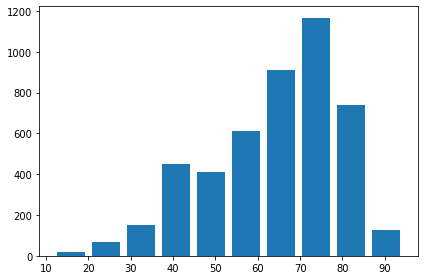

In [263]:
plt.figure()
plt.hist(brancher_score['Score_Indekseret_Normaliseret'],bins = 10, rwidth=0.8)
plt.locator_params(axis='x', nbins=10)
plt.tight_layout()
plt.show()


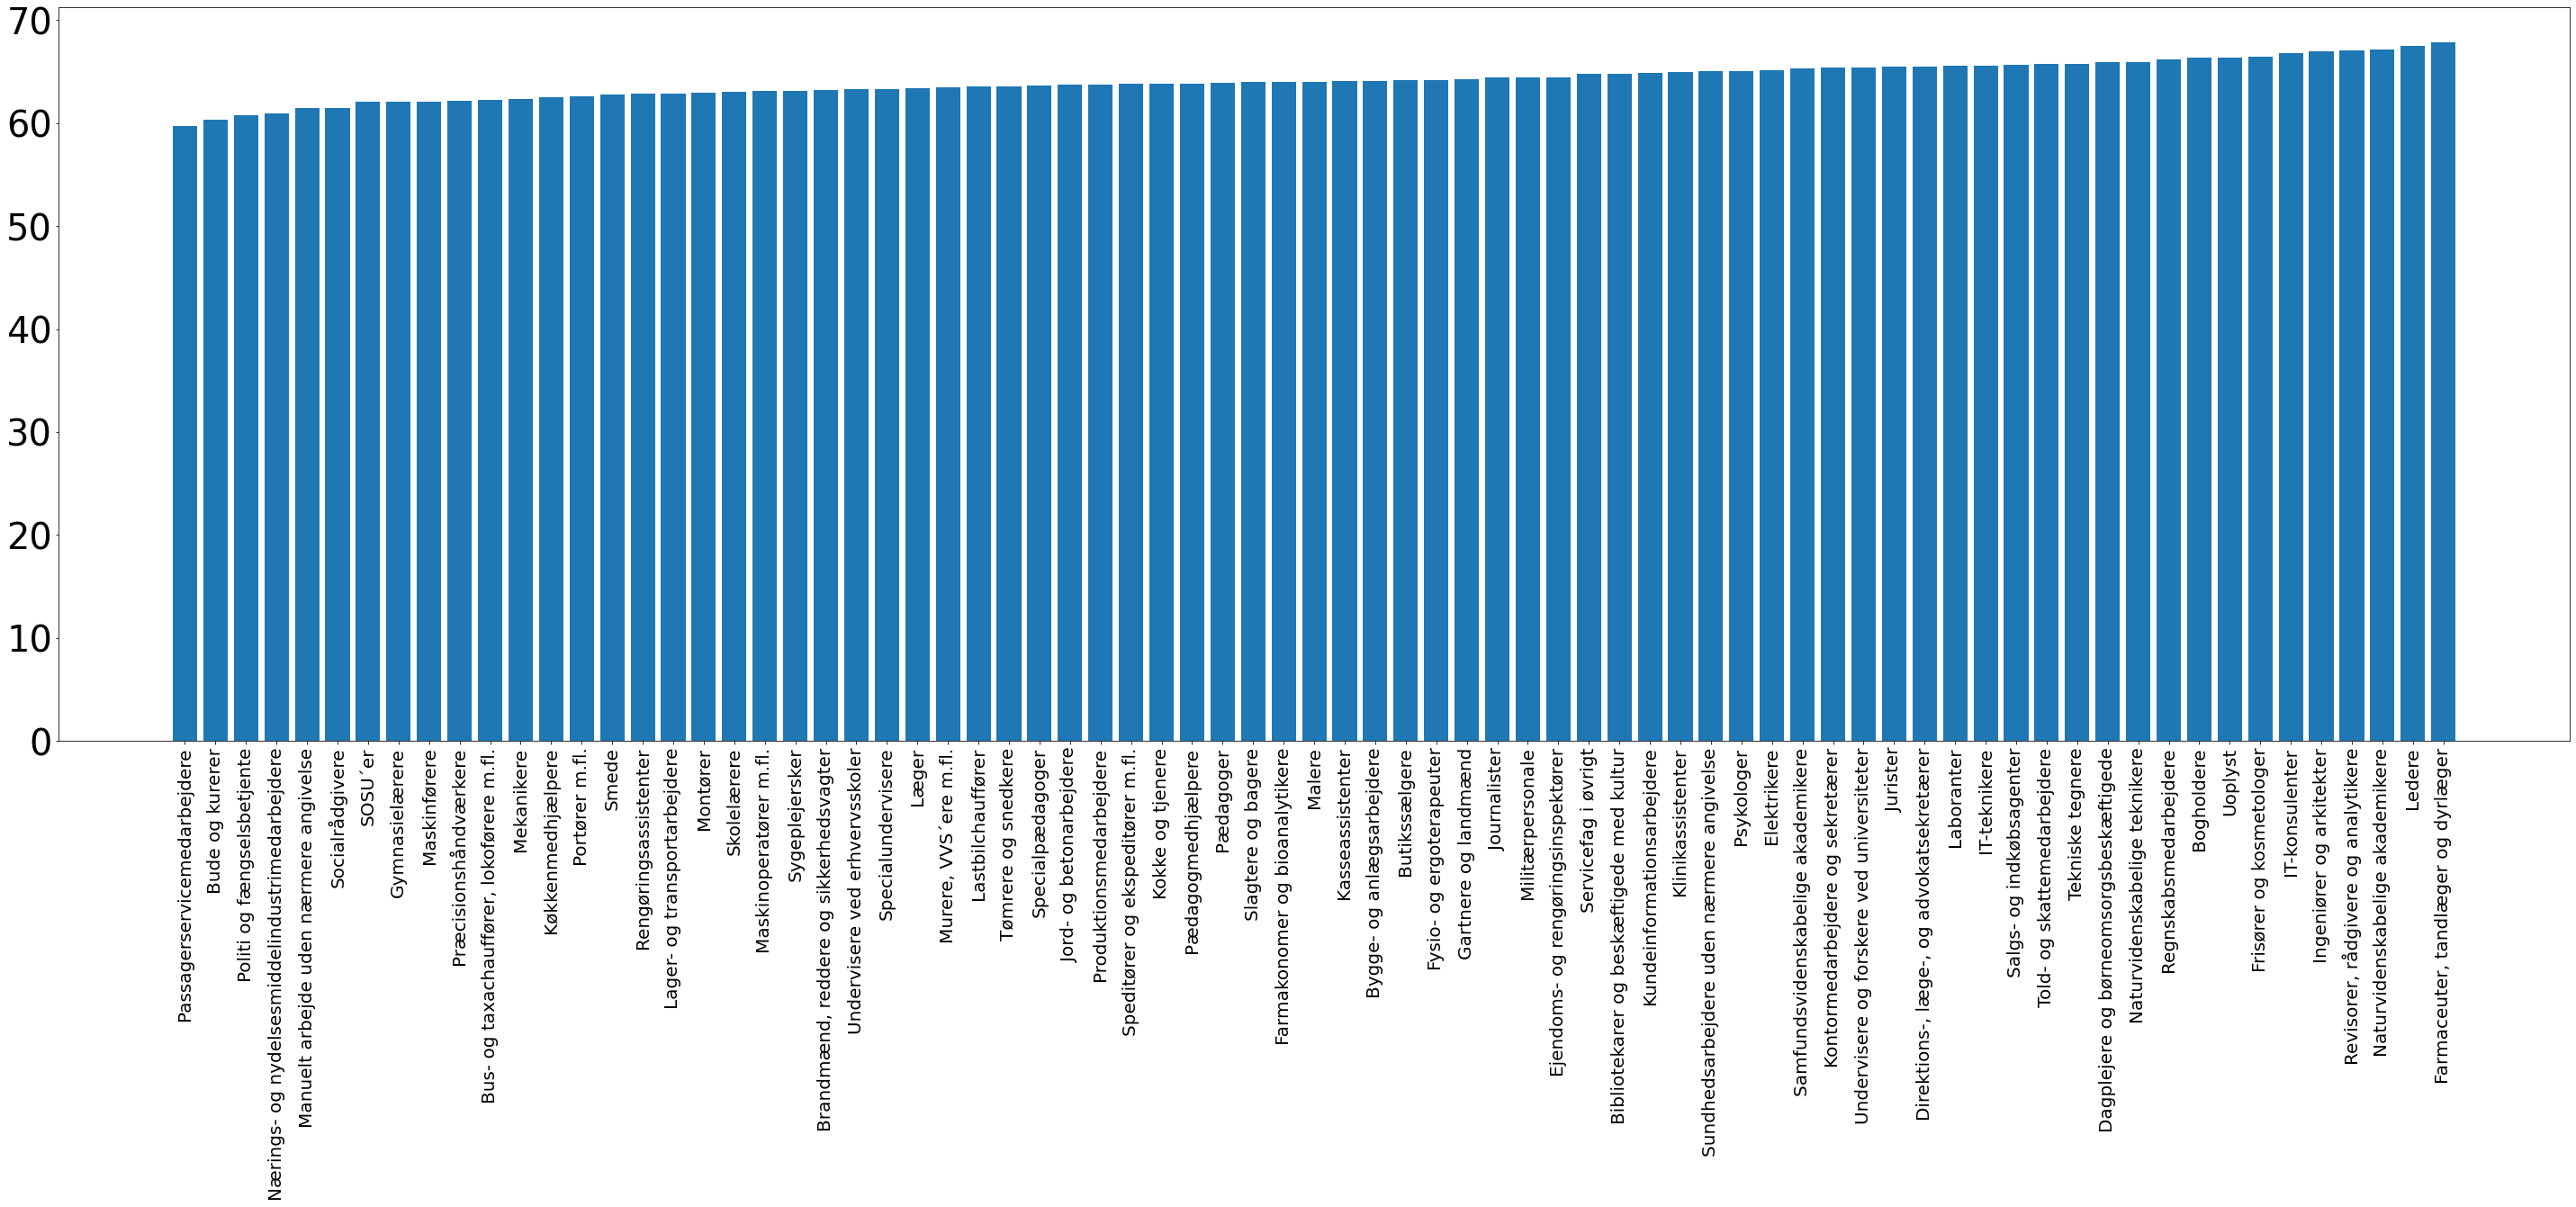

In [288]:
brancher_grouped_sorted = brancher_score.groupby(['Group']).mean().sort_values(by=['Score_Indekseret_Normaliseret'])

# brancher_.sort_values(by=['Score_Indekseret_Normaliseret'])

plt.figure(figsize=(50,15))
# Create bars and choose color
x = brancher_grouped_sorted.index
y = brancher_grouped_sorted['Score_Indekseret_Normaliseret']
plt.bar(brancher_grouped_sorted.index, brancher_grouped_sorted['Score_Indekseret_Normaliseret'])
 
plt.xticks(brancher_grouped_sorted.index, rotation='vertical', size=20) 

# plt.ylim(np.min(y)-5,np.max(y)+5)
plt.yticks(size=40)  
# # Create names
# plt.xticks(y_pos, bars)
 
# Show gra
plt.show()




In [123]:


# s = brancher_filter.groupby('Group')['Score_Indekseret_Normaliseret2'].apply(list)



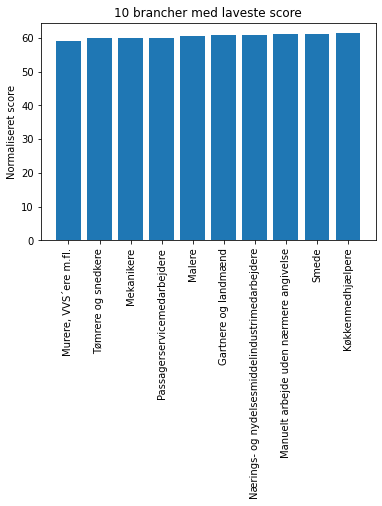

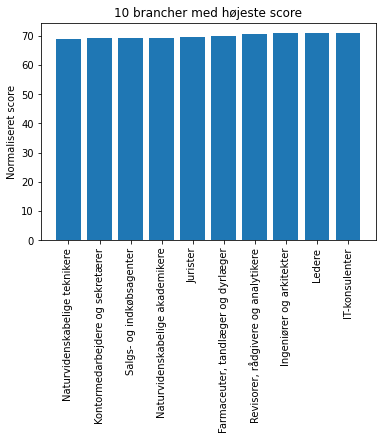

In [213]:
x = brancher_grouped_sorted.index[:10]
y = brancher_grouped_sorted['Score_Indekseret_Normaliseret2'][:10]

x2 = brancher_grouped_sorted.index[-10:]
y2 = brancher_grouped_sorted['Score_Indekseret_Normaliseret2'][-10:]



plt.figure()
plt.bar(x, y)
# Add title and axis names
plt.title('10 brancher med laveste score')
plt.ylabel('Normaliseret score')
plt.xticks(x, rotation='vertical')
plt.show()


plt.figure()
plt.bar(x2, y2)
# Add title and axis names
plt.title('10 brancher med højeste score')
plt.ylabel('Normaliseret score')
plt.xticks(x2, rotation='vertical')
plt.show()


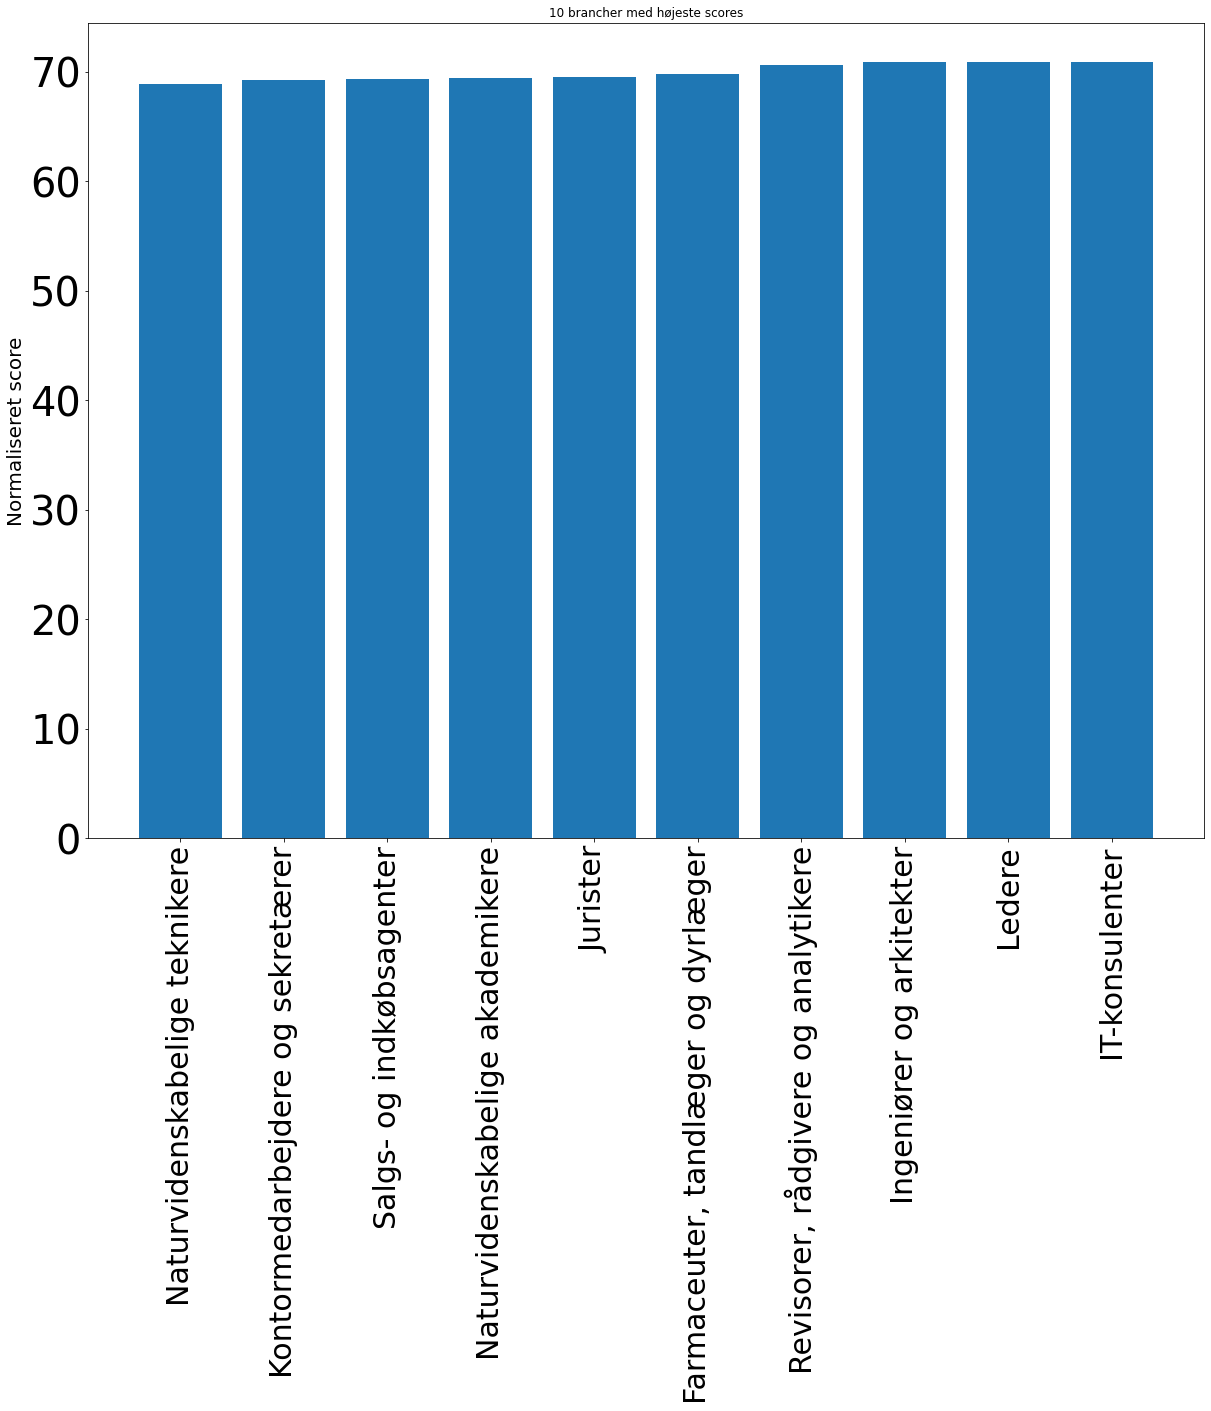

In [89]:
plt.figure(figsize=(20,15))
# Create bars and choose color
x = brancher_grouped_sorted.index[:10]

y = brancher_grouped_sorted['Score_Indekseret_Normaliseret2'][:10]
y2 = brancher_grouped_sorted['Score_Indekseret_Normaliseret2'][-10:]

plt.bar(x2, y2)
 
# Add title and axis names
plt.title('10 brancher med højeste scores')
# plt.xlabel('categories')
plt.ylabel('Normaliseret score', size=20)
plt.xticks(x2, rotation='vertical', size=30) 
plt.yticks(size=40) 
# # Limits for the Y axis
# plt.ylim(0,60)
 
# # Create names
# plt.xticks(y_pos, bars)
 
# Show gra
plt.show()

- Ud fra de to plots ses en tendens til, at dem med ikke så lang uddannelse og/eller hårdt fysisk arbejde scorer gennemsnitligt lavt, mens dem med høj uddanelse scorer gennemsnitligt højt.


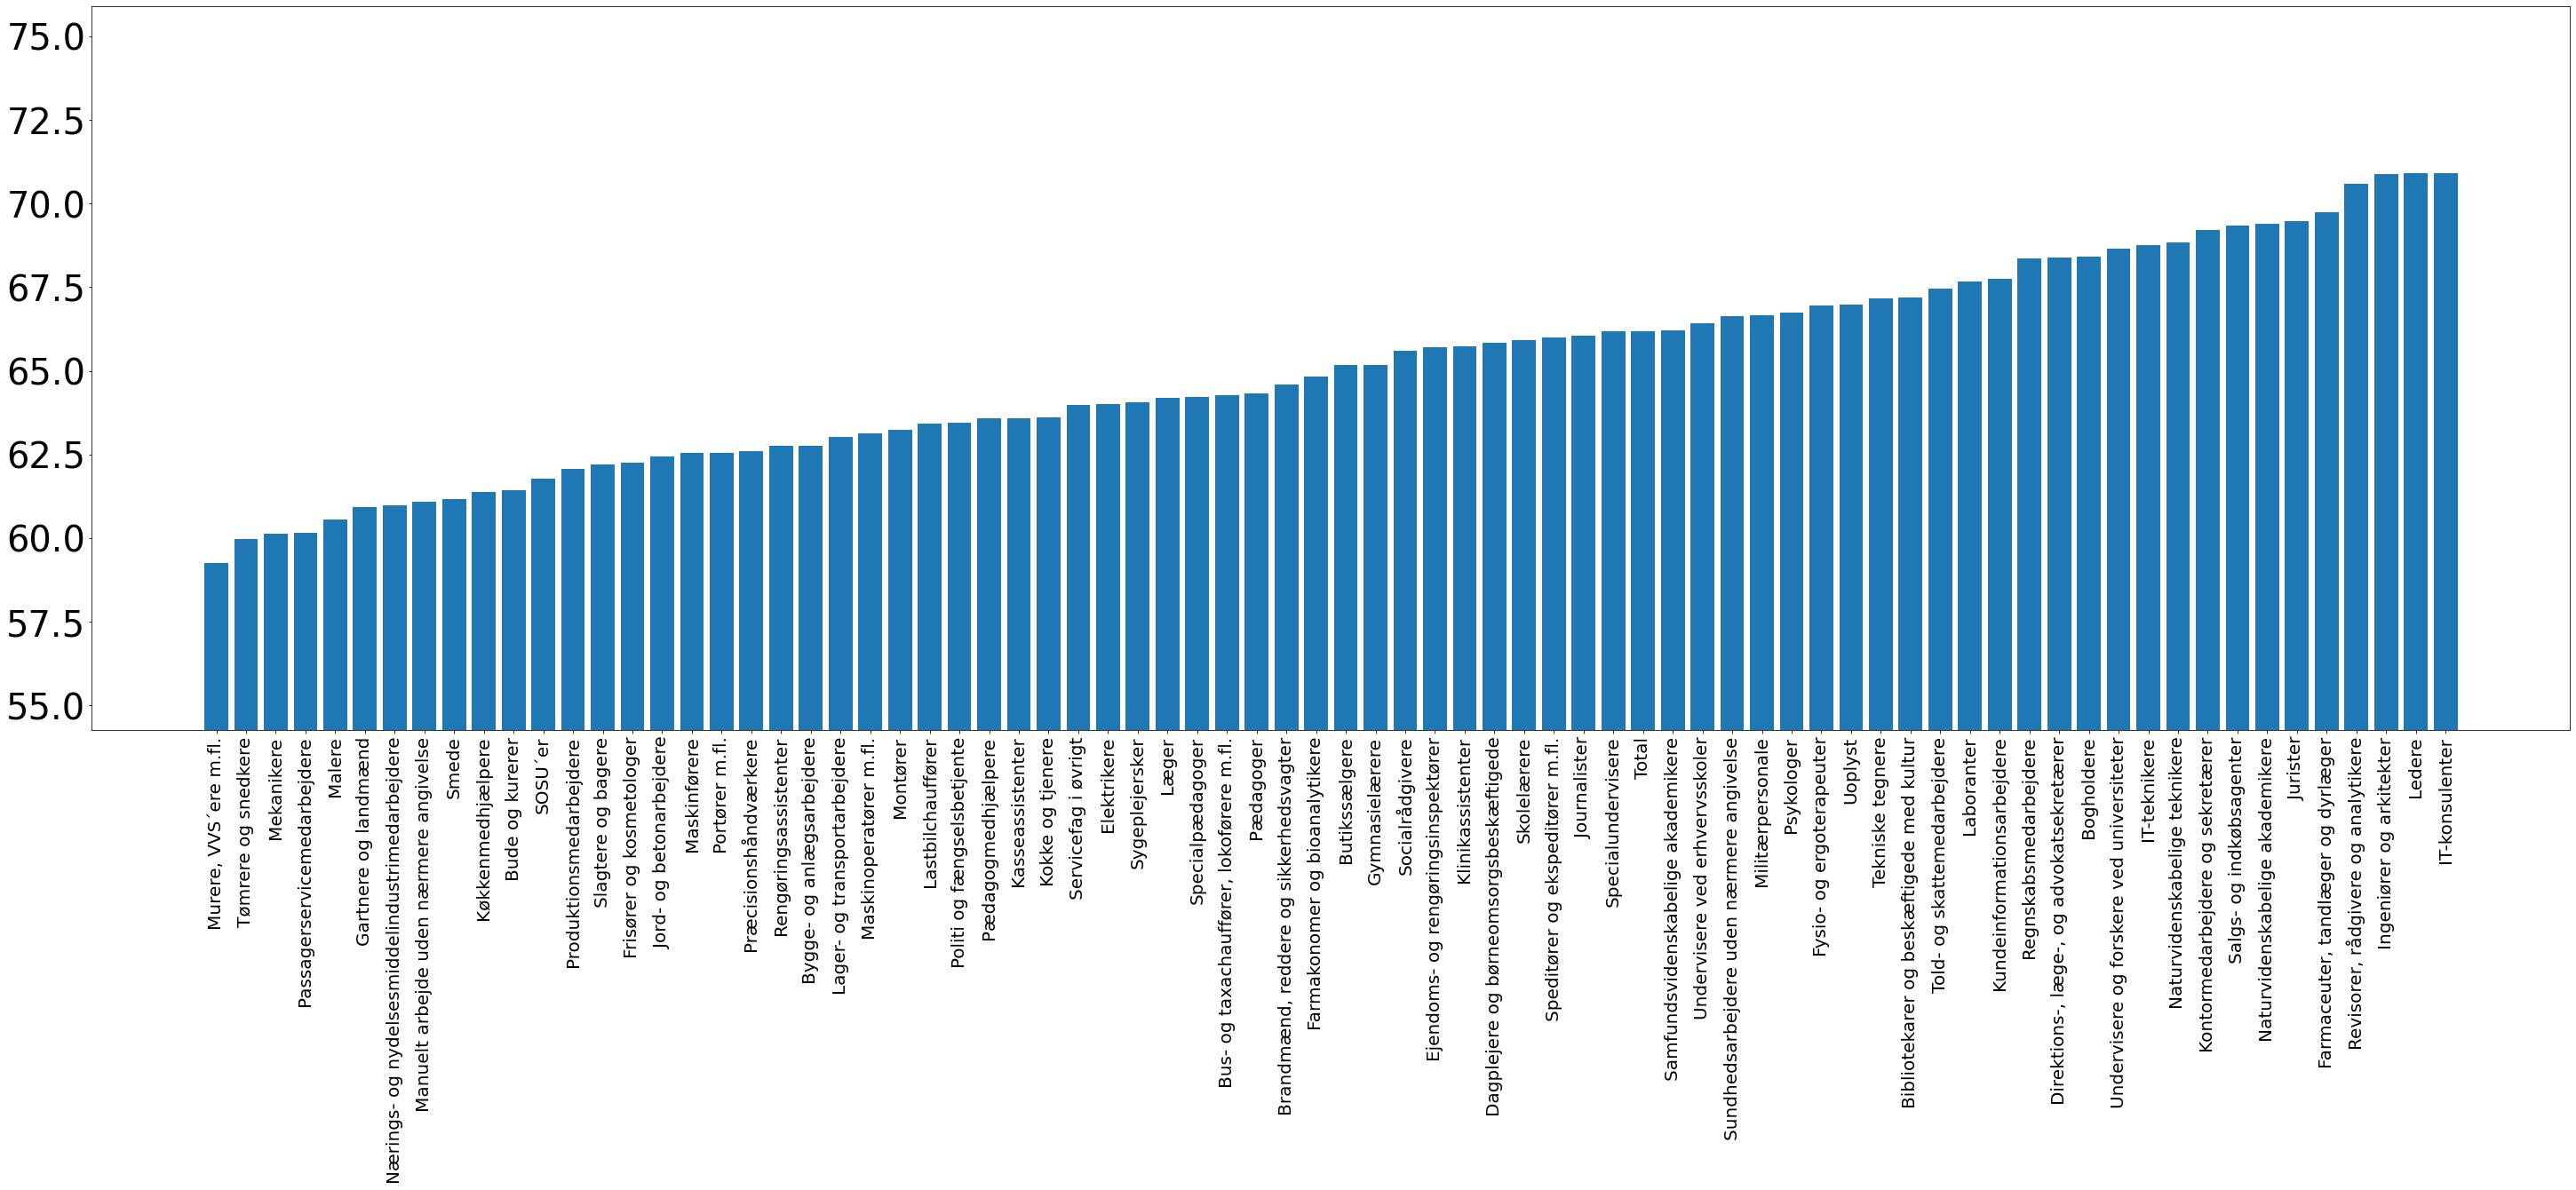

In [91]:
# brancher[brancher["Group"].str.contains("Biblio")]
print("unikke spørgsmål: " + str(len(brancher["Question Label"].unique())))
print("unikke brancher: " + str(len(brancher["Group"].unique())))
print("unikke brancher: " + str(len(brancher["Group"].unique())))


unikke spørgsmål: 109
unikke brancher: 76
unikke brancher: 76


# PCA

In [ ]:
pca_data = brancher_score.groupby('Group')['Score_Indekseret_Normaliseret'].apply(list)
# s['Bibliotekarer og beskæftigede med kultur']
s

In [265]:
questionsFiltered = brancher_score.pivot_table(index='Question Label',columns='Group',aggfunc=len).dropna().index
df_questions_filtered = brancher_score[brancher_score['Question Label'].isin(questionsFiltered)].sort_values(by=['Group', 'Question Label'])
df_questions_filtered


,Group,Akse,Topic Label,Question Label,Antpct,Antpers,Hoej Score Godt,Field Values Index,Field Values Index (Fixed),Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score,Field Values,Mean,Score_Indekseret_Normaliseret
608,Bibliotekarer og beskæftigede med kultur,Score,Konflikter mellem arbejde og privatliv,Arbejde tager energi fra privatliv,NaN,224,0,42.163623,58.563367,56.125955,2.806298,-2.806298,NaN,58.659842,NaN,2.932992,-2.932992,2.932992,41.340158
684,Bibliotekarer og beskæftigede med kultur,Score,Konflikter mellem arbejde og privatliv,Arbejde tager tid fra privatliv,NaN,224,0,45.570938,62.049324,51.199374,2.559969,-2.559969,NaN,54.163947,NaN,2.708197,-2.708197,2.708197,45.836053
2736,Bibliotekarer og beskæftigede med kultur,Score,Engagement og mening i arbejdet,Arbejdet giver selvtillid og arbejdsglæde,NaN,225,1,82.845274,62.522518,75.645633,3.782282,3.782282,NaN,78.957429,NaN,3.947871,3.947871,3.947871,78.957429
8039,Bibliotekarer og beskæftigede med kultur,Score,Arbejdsevne,Arbejdsevne,NaN,222,1,53.463140,49.886515,83.393331,8.339333,8.339333,NaN,83.812694,NaN,8.381269,8.381269,8.381269,83.812694
3344,Bibliotekarer og beskæftigede med kultur,Score,Arbejdspladsens prioritering af arbejdsmiljø,Arbejdsmiljøet skal være bedre end reglerne kræver,NaN,200,1,74.084492,65.062111,54.645973,2.732299,2.732299,NaN,56.094108,NaN,2.804705,2.804705,2.804705,56.094108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,Uoplyst,Score,Sikkerhed på arbejdspladsen,Vejledning og instruktion i sikker udførelse,NaN,2486,1,59.329533,48.838761,63.171155,3.158558,3.158558,NaN,64.747542,NaN,3.237377,3.237377,3.237377,64.747542
2735,Uoplyst,Score,Engagement og mening i arbejdet,Veloplagt på arbejdet,NaN,3174,1,72.280897,52.285451,74.233354,3.711668,3.711668,NaN,76.256813,NaN,3.812841,3.812841,3.812841,76.256813
3191,Uoplyst,Score,Sikkerhed på arbejdspladsen,Vi hjælper hinanden med altid at arbejde sikkert,NaN,2495,1,72.952893,58.993069,62.902909,3.145145,3.145145,NaN,64.713982,NaN,3.235699,3.235699,3.235699,64.713982
3647,Uoplyst,Score,Ledelseskvalitet,Virksomhedens mål forklaret i forhold til opgaver,NaN,2881,1,70.033933,51.551668,67.250412,3.362521,3.362521,NaN,70.317940,NaN,3.515897,3.515897,3.515897,70.317940


Omdan data til PCA format

In [269]:
pca_data = df_questions_filtered.groupby('Group')['Score_Indekseret_Normaliseret'].apply(np.array)
y = pca_data.index.tolist()
x = np.vstack(pca_data)
x = StandardScaler().fit_transform(x)

In [279]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)

In [284]:
PCA_components = pd.DataFrame(principalComponents)

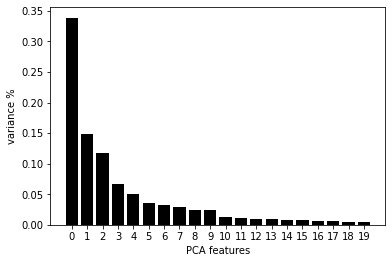

In [283]:
plt.figure()
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

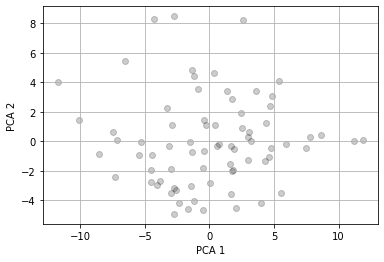

In [286]:
plt.figure()
plt.scatter(PCA_components[0], PCA_components[1], alpha=.2, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()

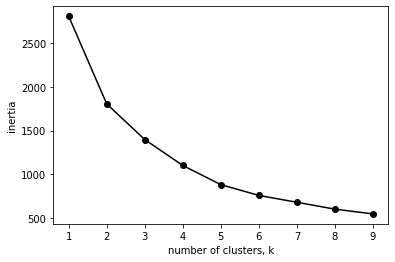

In [287]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [273]:
finalDf = pd.concat([principalDf, pd.Series(pca_data.index)], axis = 1)
finalDf

,PC 1,PC 2,Group
0,2.473839,1.952407,Bibliotekarer og beskæftigede med kultur
1,4.319168,-1.318364,Bogholdere
2,-3.170674,-0.297863,"Brandmænd, reddere og sikkerhedsvagter"
3,-10.105603,1.480076,Bude og kurerer
4,-7.302397,-2.432483,"Bus- og taxachauffører, lokoførere m.fl."
...,...,...,...
70,2.972040,0.299688,Told- og skattemedarbejdere
71,-2.578193,-3.286079,Tømrere og snedkere
72,5.368032,4.110753,Undervisere og forskere ved universiteter
73,-1.226216,4.398961,Undervisere ved erhvervsskoler


In [188]:
import colorsys
N = 76
colors = [(x*1.0/N, 0.5, 0.5) for x in range(N)]


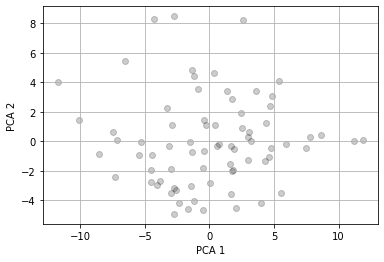

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

([<matplotlib.axis.XTick at 0x29acc889700>,
 [Text(0, 0, ''), Text(0, 0, '')])

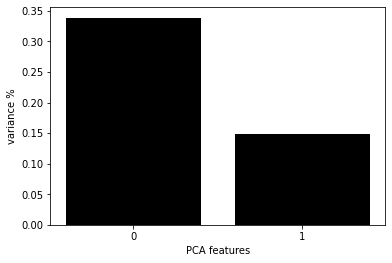

In [278]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# principalComponents

